In [ ]:
# to use gpu
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
! pip install transformers

# NLP packages
! pip install nltk -U

! pip install wordcloud
! pip install datasets

! pip install accelerate
! pip install sentence_transformers

! pip install seaborn

In [ ]:
import torch
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import ngrams

In [2]:
alldata = pd.read_excel('alldata.xlsx', sheet_name="alldata")

agg_dict = {col: 'last' for col in alldata.columns if col != 'FOI_TEXT' and col != "MDR_REPORT_KEY"}
agg_dict['FOI_TEXT'] = lambda x: " ".join(x.astype(str))
data = alldata.groupby("MDR_REPORT_KEY").agg(agg_dict).reset_index()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device", device)

device cpu


### Task1 : Finding adverse events with Biomedical NER  
- To find more AEs, get labeled dataset then train ClinicalBERT to get overlapped AEs (Ideal failed as ClinicalBERT did not identify the AEs correctly)

In [3]:
TEXTS = data[["MDR_REPORT_KEY", "FOI_TEXT"]]# [:1000]
results = {}
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

for index, row in TEXTS.iterrows():
    # tokenization + removing special characters
    word = re.sub('[^A-Za-z0-9]+', ' ',row["FOI_TEXT"].lower())
    word = re.sub(r'\d', ' ', word)           
    tokens = word_tokenize(word)
    # removing stopwords
    # filtered_tokens = [x for x in tokens if x not in stop_words and len(x) > 1]
    # lemmatization
    # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    results[row["MDR_REPORT_KEY"]] = tokens # lemmatized_tokens

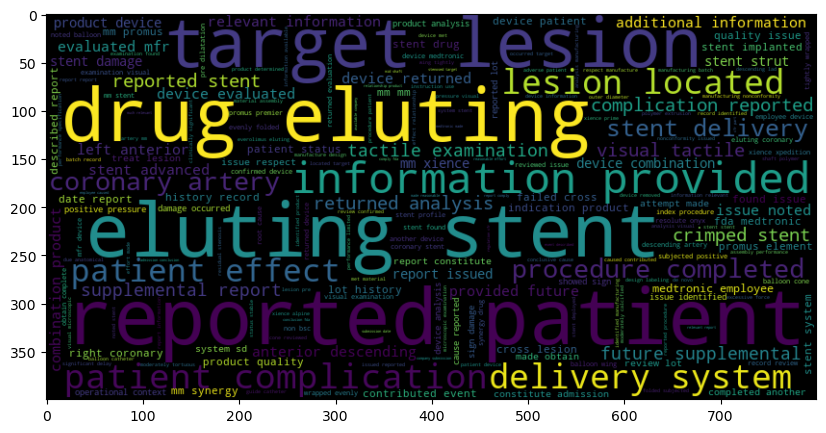

In [ ]:
from wordcloud import WordCloud

trigrams = []
for index, row in results.items():
    temp = list(ngrams(row, 4))
    trigrams.extend(" ".join(x) for x in temp)

wordcloud = WordCloud(width=800, height=400).generate(" ".join(trigrams))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from torch.utils.data import Dataset, TensorDataset

# models trained on clinical report case
# ner_prediction, pdf_annotate
# https://pmc.ncbi.nlm.nih.gov/articles/PMC9931203/
MODEL_NAME = "d4data/biomedical-ner-all"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)

nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0)

In [35]:
haha = {}
batch_input = [" ".join(value) for value in results.values()]

### get the results from models via pipeline
res = nlp_ner(batch_input)

# format them into haha = {"Detailed_description": {"..",".."}, "Sign_symptom" : {"..",".."}}
for j in res:
    for i in j:
        if i["entity_group"] not in haha.keys():
            haha[i["entity_group"]] = set(i["word"])
        else:
            ls = haha[i["entity_group"]]
            ls.add(i["word"])
            haha[i["entity_group"]] = ls

In [ ]:
hehe = {key: list(value) for key, value in haha.items()}

# Find the maximum length of any row
max_length = max(len(row) for row in hehe.values())

# Automatically fill the shorter rows with None (or NaN)
for key, value in hehe.items():
    if len(value) < max_length:
        # Fill missing values with None or NaN
        hehe[key] += [None] * (max_length - len(value))  # Or use `np.nan`

# Create the DataFrame from the modified data
df = pd.DataFrame.from_dict(hehe)
df.to_excel(f"model_results_withoutstopwords_{datetime.now().strftime('%Y%m%d-%H%M%S')}.xlsx", index=False)

NameError: name 'haha' is not defined

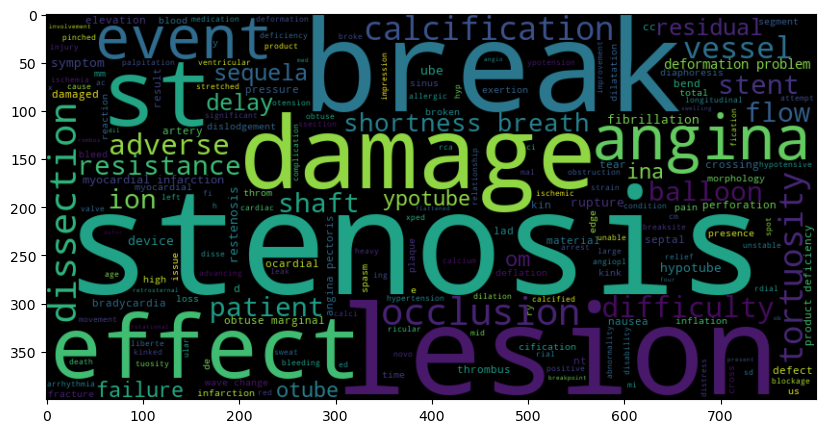

[('#', 450),
 ('stenosis', 26),
 ('break', 19),
 ('lesion', 18),
 ('angina', 15),
 ('damage', 15),
 ('st', 13),
 ('effect', 13),
 ('event', 10),
 ('occlusion', 10),
 ('dissection', 10),
 ('calcification', 10),
 ('tortuosity', 10),
 ('vessel', 9),
 ('difficulty', 9),
 ('adverse', 9),
 ('shaft', 8),
 ('ion', 8),
 ('myocardial', 8),
 ('infarction', 8),
 ('shortness', 8),
 ('breath', 8),
 ('resistance', 8),
 ('stent', 8),
 ('balloon', 8),
 ('flow', 8),
 ('deformation', 8),
 ('patient', 8),
 ('residual', 7),
 ('sequela', 7)]

In [ ]:
columns = ["Sign_symptom"]
combined = list()
for i in columns:
    combined.extend(haha[i])

# print the word cloud again
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=400).generate(" ".join(combined))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

text = []
for ix in combined:
    text += word_tokenize(str(ix))

from collections import Counter
Counter(text).most_common(30)


In [ ]:
### TBC (In case if you want to find more AEs) - but for now should be good enough
# train ClinicalBERT (BioBERT & trained on all MIMIC notes) for finding AEs
# I have used biomedical NER to find all AEs - from here can do labelled dataset
MODEL_NAME1 = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer1 = AutoTokenizer.from_pretrained(MODEL_NAME1)
model1 = AutoModelForTokenClassification.from_pretrained(MODEL_NAME1)

nlp_ner_biobert = pipeline("ner", model=model1, tokenizer=tokenizer1, aggregation_strategy="simple", device=0)
## required labelled dataset, and fine-tuned from there

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


### Task 2: Use K-means clustering/GPT/TopicBERT to find bigger cluster of these AEs
- These adverse events by NER model has been manually reviewed to ensure the correctness of each adverse events
- https://www.meddra.org/mapping

#### Trial 1: Embedding using ClinicalBERT model + Kmeans
- Not good result (Retrained for 2nd times)

In [3]:
# only tokenization, no stopword removal & lemmatization (keep the original format and see which AEs still there, that's likely to be the real one)
model_results = pd.read_excel("./model_results_withoutstopwords_20250418-171933.xlsx", sheet_name="Sign_symptom")
adverse_events = model_results["Sign_symptom"].to_list()

In [4]:
### K-means

### load tokenizer and model for ClinicalBERT
from transformers import AutoTokenizer, AutoModel
# https://arxiv.org/abs/1904.03323
MODEL_NAME1 = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer_clinicalBERT = AutoTokenizer.from_pretrained(MODEL_NAME1)
model_clinicalBERT = AutoModel.from_pretrained(MODEL_NAME1, device_map="cuda")
def get_embedding(text):
    with torch.no_grad():

        # process input text (pads + splice sequence to length 512)
        inputs = tokenizer_clinicalBERT(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        # move input to gpu
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # inputs: dict_keys(['input_ids', 'token_type_ids', 'attention_mask']) 
        # input_ids = tokenized input text, attention_mask: 1 (actual words)/0 (padding tokens)
        # outputs odict_keys(['last_hidden_state', 'pooler_output'])
        outputs = model_clinicalBERT(**inputs)
        
    last_hidden_state = outputs.last_hidden_state
    attention_mask = inputs["attention_mask"]

    # Mean Pooling
    mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    sum_embeddings = torch.sum(last_hidden_state * mask_expanded, 1)
    sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
    embedding = sum_embeddings / sum_mask

    return embedding.squeeze().cpu().numpy()


embeddings = [get_embedding(ae) for ae in adverse_events] 

D:\Users\a1910341\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Users\a1910341\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\Users\a1910341\.cache\huggingface\hub\models--emilyalsentzer--Bio_ClinicalBERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an admin

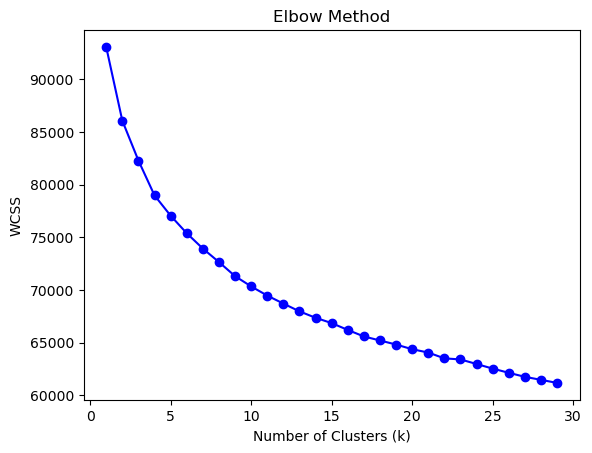

In [82]:
# Elbow Method - to decide how many clusters should I have 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
K_range = range(1, 30)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

### Elbow graph never flatten, not good methods to decide how many clusters should we have

In [83]:
from sklearn.decomposition import PCA

num_clusters = 22  # you can experiment with this
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

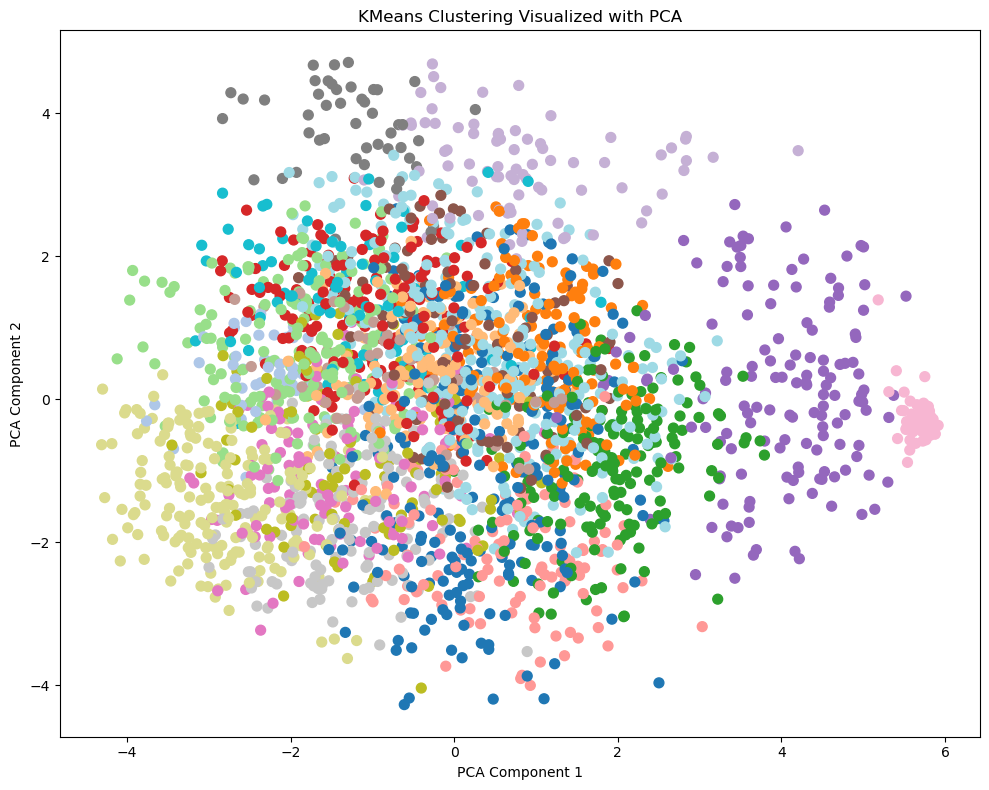

In [84]:
import matplotlib.pyplot as plt
# PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab20', s=50)

# Optional: add legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().add_artist(legend1)

plt.title('KMeans Clustering Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()

In [ ]:
# Display results
groups = {}
for text, label in zip(adverse_events, labels):
    if label in groups.keys():
        temp = groups[label]
        temp.append(text)
        groups[label] = temp
    else:
        groups[label] = [text]
    
    # print(f"[Cluster {label}] {text}")


# Find the maximum length of any row
max_length = max(len(row) for row in groups.values())

# Automatically fill the shorter rows with None (or NaN)
for key, value in groups.items():
    if len(value) < max_length:
        # Fill missing values with None or NaN
        groups[key] += [None] * (max_length - len(value))  # Or use `np.nan`

group_df = pd.DataFrame(groups)

group_df.to_csv(f"groups_{datetime.now().strftime('%Y%m%d-%H%M%S')}.csv", index=False)


#### Refine for 2nd times (because some clusters are mixed up with other clusters)

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

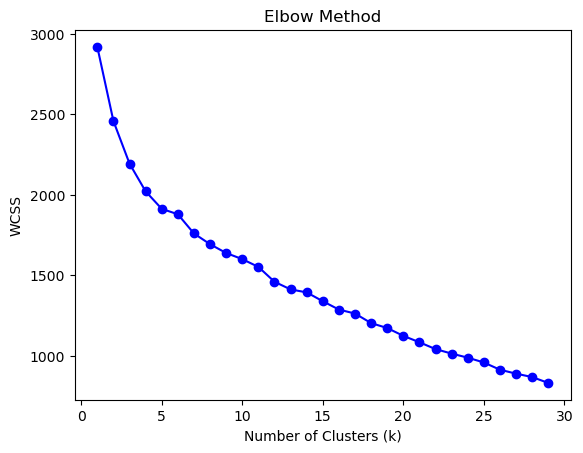

In [5]:
# only tokenization, no stopword removal & lemmatization (keep the original format and see which AEs still there, that's likely to be the real one)
refined_model_results = pd.read_excel("./model_results_toberefined.xlsx")
refined_adverse_events = []
refined_model_results.dropna(axis=0, how='any', inplace=True)
for index, row in refined_model_results.items():
    refined_adverse_events.extend(row)

refined_embeddings = [get_embedding(ae) for ae in refined_adverse_events] 

# Elbow Method - to decide how many clusters should I have 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
K_range = range(1, 30)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(refined_embeddings)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


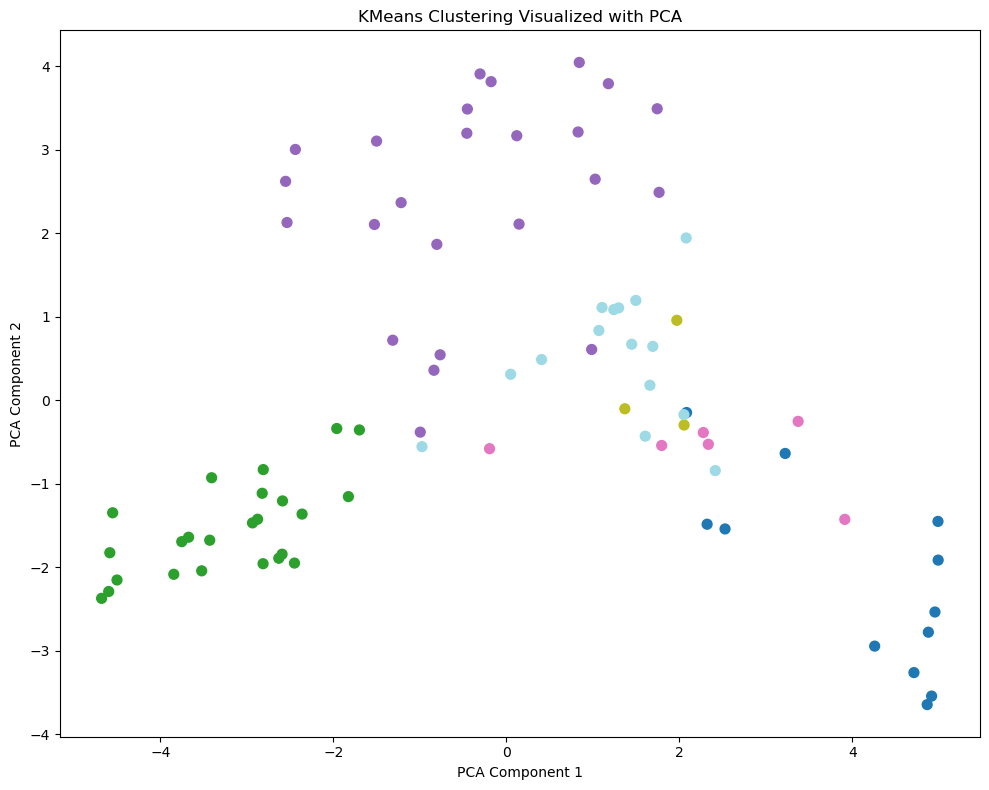

In [7]:
from sklearn.decomposition import PCA

num_clusters = 6  # you can experiment with this
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(refined_embeddings)

import matplotlib.pyplot as plt
# PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced = pca.fit_transform(refined_embeddings)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab20', s=50)

# Optional: add legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().add_artist(legend1)

plt.title('KMeans Clustering Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()

- These clusters will be combined with the original 1st attempt clusters

#### Trial 2: Embedding using BioLORD + Kmeans
- Did not use in the end, the clustering looks messy)

In [8]:
### Trial 2: with GPT model
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

MODEL_NAME1 = 'FremyCompany/BioLORD-2023-C' #"openai-community/gpt2"
# "emilyalsentzer/Bio_ClinicalBERT"
tokenizer_lBERT = AutoTokenizer.from_pretrained(MODEL_NAME1)
model_BERT = AutoModel.from_pretrained(MODEL_NAME1, device_map="cuda")
def get_embedding(text):
    with torch.no_grad():
        # process input text (pads + splice sequence to length 512)
        inputs = tokenizer_lBERT(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        # move input to gpu
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # inputs: dict_keys(['input_ids', 'token_type_ids', 'attention_mask']) 
        # input_ids = tokenized input text, attention_mask: 1 (actual words)/0 (padding tokens)
        # outputs odict_keys(['last_hidden_state', 'pooler_output'])
        outputs = model_BERT(**inputs)
        
    last_hidden_state = outputs.last_hidden_state
    attention_mask = inputs["attention_mask"]    

    # Mean Pooling
    mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    sum_embeddings = torch.sum(last_hidden_state * mask_expanded, 1)
    sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
    embedding = sum_embeddings / sum_mask

    # Normalize embeddings
    embedding = F.normalize(embedding, p=2, dim=1)

    return embedding.squeeze().cpu().numpy()


embeddings = [get_embedding(ae) for ae in adverse_events] 

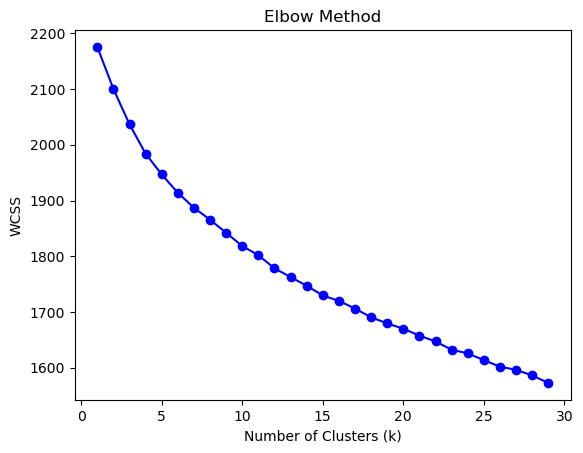

In [9]:
# Elbow Method - to decide how many clusters should I have 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
K_range = range(1, 30)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [10]:
from sklearn.decomposition import PCA

num_clusters = 21  # you can experiment with this
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

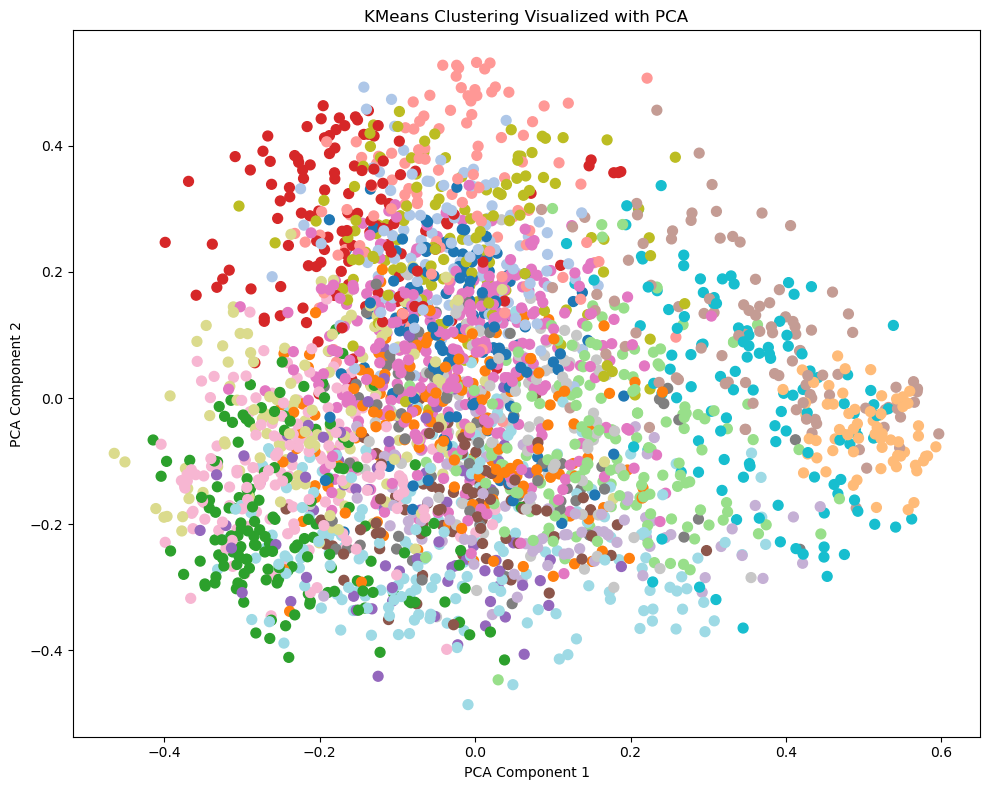

In [11]:
import matplotlib.pyplot as plt
# PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab20', s=50)

# Optional: add legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().add_artist(legend1)

plt.title('KMeans Clustering Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()

### Task 3: Identify trends of patient age groups/report counts/gender/manufacturers/products for these clusters over 10 years basis

In [ ]:
### tag the report with the categories based on these keywords
ae_groups = pd.read_csv("./groups_byClinicalBERT.csv")

group_results = []
for index, report in results.items():
    foi_text = ' '.join(report)
    tagged = set()
    for group_name, group_words in ae_groups.items():
        keywords = [x for x in group_words.tolist() if isinstance(x, str)]
        if any(keyword in foi_text for keyword in keywords):
            tagged.add(group_name)
    
    group_results.append({
        "MDR_REPORT_KEY": index,
        "FOI_TEXT": foi_text,
        "CATEGORIES": list(tagged)
    })
    
group_results = pd.DataFrame(group_results)
group_results.head(5)

# combining the categories with original data
combined = pd.merge(group_results[["MDR_REPORT_KEY", "CATEGORIES"]], data, on="MDR_REPORT_KEY", how="left")


In [40]:
#### CLEANING for "PATIENT_AGE" column

# return null for all the age is at least 150, so we can ignore them from analysis
def anomaly(age):
    if int(age) >= 150:
        return None
    else:
        return float(age)
    
def age_cleaning(age):
    age = str(age)
    try:
        if age != "nan":
            if "DA" in age:
                return anomaly(float(re.sub(r"DA", "", age)) / 365)
            elif "MO" in age:
                return anomaly(float(re.sub(r"MO", "", age)) / 12)
            elif "YR" in age:
                return anomaly(float(re.sub(r"YR", "", age)))
            else:
                # assuming this numbers are based in YR
                # print("whyyyy", age)
                pass
                
    except Exception as e:
        print(e, age)
        return age

combined["PATIENT_AGE"] = combined["PATIENT_AGE"].apply(lambda x : age_cleaning(x))

#### CLEANING for "PATIENT_WEIGHT" column
combined["PATIENT_WEIGHT"] = combined["PATIENT_WEIGHT"].apply(lambda x : float(re.sub(r"KG", "", str(x))) if x is not None else None)

# Flatten the combined data
flatten_combined = combined.explode('CATEGORIES').reset_index(drop=True)

###### remove the outliers for patient weight with z-score
from scipy import stats
df_weight = combined.dropna(subset=['PATIENT_WEIGHT'])
# Calculate Z-scores
z_scores = stats.zscore(df_weight['PATIENT_WEIGHT'])
df_filtered_weight = df_weight[(abs(z_scores) < 3)]
###### END

###### remove the outliers for patient age with z-score
from scipy import stats
df_age = combined.dropna(subset=['PATIENT_AGE'])
# Calculate Z-scores
z_scores = stats.zscore(df_age['PATIENT_AGE'])
df_filtered_age = df_age[(abs(z_scores) < 3)]
###### END

In [ ]:
combined.to_csv("final_results.csv", index=False)

#### Please continue with [Task 3 & 4.ipynb] as this notebook has exceed its memory